## Starter file for assignment on Clustering
### Author: Chengze Liu
### UH ID: 2316609

In [26]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram


In [27]:
# load data
data = pd.read_csv("air_quality.csv")

# create numerical labels for categorical variable air quality
air_quality_labels = {"Hazardous":0, "Poor":1, "Moderate":2, "Good":3}
data["Air Quality"] = data["Air Quality"].map(air_quality_labels)
data[["Air Quality"]]

,Air Quality
0,2
1,2
2,2
3,3
4,3
...,...
4995,0
4996,2
4997,2
4998,3


### Task 1: Function for computing purity
This is your function of purity.

The indices of the clusters in `y_true` and `y_pred` start from 0 in `compute_purity`, e.g., [1, 1, 0, 0, 2, 2, 2].

`y_true` is the array of true class indices of all data points, `len(y_true)=number of data points`.

`y_pred` is the array of cluster indices of all data points, `len(y_pred)=number of data points`.

In [28]:
def compute_purity(y_true, y_pred):
    # This is your function of purity
    # y_true is the array of true class indices of all data points, len(y_true)=number of data points
    # y_pred is the array of cluster indices of all data points, len(y_pred)=number of data points

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    total_samples = len(y_true)
    unique_clusters = np.unique(y_pred)
    
    # Sum of majority class counts in each cluster
    majority_sum = 0
    
    for cluster in unique_clusters:
        # Indices of samples belonging to this cluster
        cluster_indices = np.where(y_pred == cluster)[0]
        # True labels of samples in this cluster
        true_labels_in_cluster = y_true[cluster_indices]
        
        # Count occurrences of each true label
        counts = np.bincount(true_labels_in_cluster)
        # Add the count of the majority class
        majority_sum += np.max(counts)
    
    # Purity = correctly clustered samples / total samples
    purity = majority_sum / total_samples

    return purity

testing compute_purity()

For example, if y_pred = [2, 2, 1, 2, 2, 2, 0, 0, 0, 1, 2, 1, 1, 1, 1, 1], y_true = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2], the purity is (4 + 3 + 5) / 16 = 75%.

Test your purity function with the above example and many other examples created by you before moving to the next tasks. Please include your test results in the report.

In [29]:
# test case one

y_pred = np.array([2, 2, 1, 2, 2, 2, 0, 0, 0, 1, 2, 1, 1, 1, 1, 1])
y_true = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2])

print(f"Purity calculated by hand: (4+3+5)/16={(4+3+5)/16}")
print(f"Purity by compute_purity(): {compute_purity(y_true, y_pred)}")
print()

# test case two: perfect clustering

y_pred = np.array([0, 0, 0, 1, 1, 2, 2, 2])
y_true = np.array([1, 1, 1, 2, 2, 0, 0, 0])

print(f"Purity calculated by hand: (3+2+3)/8={(3+2+3)/8}")
print(f"Purity by compute_purity(): {compute_purity(y_true, y_pred)}")
print()

# test case three: more label classes than clusters

y_pred = np.array([0,0,0,1,1,1,1,2,2,2,2,2])
y_true = np.array([0,0,1,2,0,1,1,2,2,3,3,3])

print(f"Purity calculated by hand: (2+2+3)/12={(2+2+3)/12:.2f}")
print(f"Purity by compute_purity(): {compute_purity(y_true, y_pred):.2f}") 

Purity calculated by hand: (4+3+5)/16=0.75
Purity by compute_purity(): 0.75

Purity calculated by hand: (3+2+3)/8=1.0
Purity by compute_purity(): 1.0

Purity calculated by hand: (2+2+3)/12=0.58
Purity by compute_purity(): 0.58


### Task 2: Function for computing sum of squared error (sse)
This is your function of sse.

The indices of the clusters in `y_pred` start from 0 in `compute_sse`, e.g., [1, 1, 0, 0, 2, 2, 2].

`x` is the array of data, `x.shape=(numbe of data points, number of attributes)`.

`y_pred` is the array of cluster indices of all data points, `len(y_pred)=number of data points`.

In [30]:
def compute_sse(x, y_pred):
    # This is your function of sse
    # x is the array of data, x.shape=(numbe of data points, number of attributes)
    # y_pred is the array of cluster indices of all data points, len(y_pred)=number of data points

    x = np.array(x)
    y_pred = np.array(y_pred)
    sse = 0.0
    clusters = np.unique(y_pred)

    for cluster in clusters:
        # Select points in this cluster
        points = x[y_pred == cluster]
        # Compute cluster centroid
        centroid = points.mean(axis=0)
        # Compute squared distances to centroid and sum
        sse += np.sum((points - centroid) ** 2)

    # Return the **average SSE per point**
    sse /= x.shape[0]

    return sse


Test your SSE function using Iris dataset Download Iris dataset: run KMeans (scikit-learn) with k=3 on the four attributes of all data points ("SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"), compare the SSE returned by your function and the SSE returned by (KMeans.inertia_ / n), where n is the number of data points. Ensure the two SSEs are equal before moving to the next tasks. Please include your test results in the report.

In [31]:
# testing compute_sse() with iris dataset
iris = pd.read_csv("Iris.csv")
iris_data = iris[["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]

# normalize the data
Scalar = StandardScaler()
iris_data = Scalar.fit_transform(iris_data)

# run kmeans on Iris dataset
km = KMeans(n_clusters=3, random_state=1) # random_state to reproduce the same result
km.fit(iris_data)

# compute sse by kmeans and compute_sse()

sse_kmeans = km.inertia_ / iris_data.shape[0]
sse = compute_sse(iris_data, km.labels_)

print(f"kmeans sse: {sse_kmeans:.5f}")
print(f"compute_sse(): {sse:.5f}")


kmeans sse: 0.94740
compute_sse(): 0.94740


### Task 3

Run K-means on the dataset with k=4. Use the default parameters in the function provided by scikit-learn for the algorithm. What percentage of the data points were assigned to each of the four clusters? Compute the purity of the clustering result. Then compute the purity of the clustering result for each of the four clusters. Which cluster has the highest purity?

In [32]:
# extract features from data
X = data.drop(columns=["Air Quality"])

# normalize
scalar = StandardScaler()
X=scalar.fit_transform(X)

# run kmeans with k=4
km = KMeans(n_clusters=4, random_state=1) # set random state for reproduction of result
km.fit(X)

# find clusters and their percentage
clusters, counts = np.unique(km.labels_, return_counts=True)

n = counts.sum()
for cluster, count in zip(clusters, counts):
    print(f"cluster {cluster}: {count/n*100:.2f}%")
print()

# compute purity
print(f"purity: {compute_purity(data["Air Quality"], km.labels_)}")
print()

# compute purity for each cluster
purity_list = []
for cluster in clusters:
    index = np.where(km.labels_ == cluster)[0]
    y_pred = km.labels_[index]
    y_true = data["Air Quality"][index]
    purity = compute_purity(y_true, y_pred)
    purity_list.append(purity)
    print(f"cluster {cluster} purity: {purity:.4f}")

print()

max_purity_index = np.where(purity_list == np.max(purity_list))[0]
print(f"cluster {clusters[max_purity_index[0]]} has the highest purity")



cluster 0: 32.84%
cluster 1: 18.48%
cluster 2: 7.32%
cluster 3: 41.36%

purity: 0.8158

cluster 0 purity: 0.8283
cluster 1 purity: 0.5974
cluster 2 purity: 0.4645
cluster 3 purity: 0.9657

cluster 3 has the highest purity


### Task 4

Run K-means on the dataset with k=2, 3, 4, 10, 20, 30. For each value of k, run K-means 10 times, compute the average purity of clustering over the 10 runs and average SSE of clustering over the 10 runs. Then create a table, as given below, for the obtained average purity and SSE. Which value of k gives the best clustering result in terms of purity? Which value of k gives the best clustering result in terms of SSE? How does purity change w.r.t. the value of k? Please explain why purity changes in this way w.r.t. the value of k.

In [33]:
# extract features from data
X = data.drop(columns=["Air Quality"])

# normalize
scalar = StandardScaler()
X=scalar.fit_transform(X)

k_list = [2, 3, 4, 10, 20, 30]

results = []
# run kmeans
for k in k_list:
    # for each k run kmeans 10 times
    purity_list = []
    sse_list = []
    for i in range(10):
        km = KMeans(n_clusters=k, random_state=i) # make sure random state is not the same 
        km.fit(X)
        purity = compute_purity(data["Air Quality"], km.labels_)
        sse = compute_sse(X, km.labels_)
        purity_list.append(purity)
        sse_list.append(sse)

    avg_purity = np.mean(purity_list)
    avg_sse = np.mean(sse_list)

    results.append((k, avg_purity, avg_sse))

results_df = pd.DataFrame(results, columns=["k", "avg_purity", "avg_sse"])
print(results_df.to_string(index=False))





 k  avg_purity  avg_sse
 2     0.59644 5.489387
 3     0.76348 4.472919
 4     0.80914 3.891763
10     0.87202 2.973289
20     0.89018 2.407288
30     0.89578 2.153647


### Task 5

Run DBSCAN on the dataset with eps=0.8, 0.9, 1.0, 1.1, 1.2, and fix minPts=5, metric=Euclidean distance, and other default parameter values. Count the total number of clusters and the total number of anomalies generated by DBSCAN, calculate the purity, SSE and Silhouette coefficient (use sklearn.metrics.silhouette_scoreLinks to an external site.) of the clustering (Note: exclude anomalies before calculating purity, SSE and Silhouette coefficient). For Silhouette coefficient, use Euclidean distance and other default parameter values. Then create a table, as given below for the obtained purity, SSE and Silhouette coefficient. Which value of eps gives the best clustering result in terms of purity? Which value of eps gives the best clustering result in terms of SSE? Which value of eps gives the best clustering result in terms of Silhouette coefficient? How do purity, SSE and Silhouette coefficient, respectively, change w.r.t. the value of eps?

In [34]:
# extract features from data
X = data.drop(columns=["Air Quality"])

# normalize
scalar = StandardScaler()
X=scalar.fit_transform(X)

eps_list = [0.8, 0.9, 1.0, 1.1, 1.2]
minPts = 5

results = []
# run dbscan on different epsilon
for eps in eps_list:
    dbs = DBSCAN(eps=eps, min_samples=minPts, metric='euclidean')
    y_pred = dbs.fit_predict(X)
    
    # identify anomalies
    anomalies = (y_pred == -1)
    
    # filter out anomalies for purity and sse calculation
    X_filtered = X[~anomalies]
    y_pred_filtered = y_pred[~anomalies]
    y_true_filtered = data["Air Quality"].to_numpy()[~anomalies]

    n_clusters = len(set(y_pred_filtered))
    n_anomalies = anomalies.sum()

    purity = compute_purity(y_true_filtered, y_pred_filtered) if n_clusters > 0 else 0
    sse = compute_sse(X_filtered, y_pred_filtered) if n_clusters > 0 else 0
    silhouette = silhouette_score(X_filtered, y_pred_filtered) if n_clusters > 1 else -1

    results.append({
        "eps": eps,
        "n_clusters": n_clusters,
        "n_anomalies": n_anomalies,
        "purity": round(purity, 4),
        "SSE": round(sse, 4),
        "Silhouette": round(silhouette, 4)
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

 eps  n_clusters  n_anomalies  purity    SSE  Silhouette
 0.8          12         2656  0.7901 2.9224     -0.0093
 0.9          11         2071  0.6664 3.6124      0.0073
 1.0           8         1532  0.5712 4.5179      0.1002
 1.1          10         1136  0.5210 5.1103      0.0974
 1.2           4          854  0.4824 5.6817      0.2271


### Task 6
Run Agglomerative Clustering with distance_threshold=25, 75, 125, n_cluster=None and other default parameter values. Draw a dendrogram of the clustering results (refer to plot_dendrogram in our lecture notebook Download lecture notebookon how to draw dendrograms, set truncate_mode='level' and p=5). Note the dendrogram does not change w.r.t. distance_threshold, so it is sufficient to place a single dendrogram in the report. Count the total number of clusters (Note: the number can be counted using the predicted labels if the dendrogram is not clear for some thresholds), calculate the purity and SSE of the clustering. Then create a table, as given below for the obtained number of clusters, purity and SSE. Please use the dendrogram (tips: with y axis grid on) to select which distance_threshold value among [22, 29, 46, 60, 91] should be used if we want to detect 5 clusters and why to select this distance_threshold value?

In [19]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    

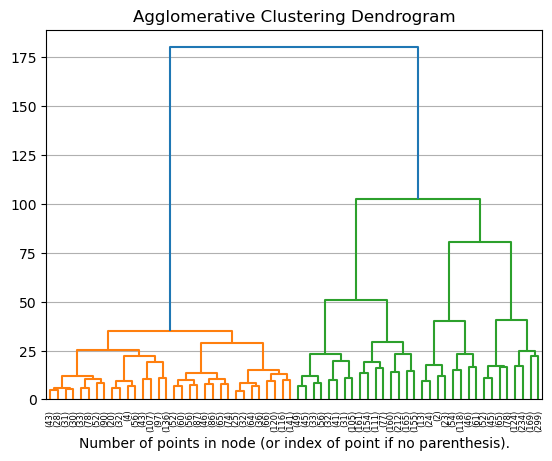

 Distance_Threshold  n_clusters  purity    SSE
                 25          11  0.8818 3.1350
                 75           4  0.8450 4.0730
                125           2  0.6940 5.7627


In [35]:
# extract features from data
X = data.drop(columns=["Air Quality"])

# normalize
scalar = StandardScaler()
X=scalar.fit_transform(X)

distance_thresholds = [25, 75, 125]
results = []

# run hierarchical clustering on different distance thresholds
for threshold in distance_thresholds:
    agc = AgglomerativeClustering(n_clusters=None, distance_threshold=threshold)
    y_pred = agc.fit_predict(X)
    n_clusters = len(set(y_pred))
    purity = compute_purity(data["Air Quality"], y_pred)
    sse = compute_sse(X, y_pred)

    results.append({
        "Distance_Threshold": threshold,
        "n_clusters": n_clusters,
        "purity": round(purity, 4),
        "SSE": round(sse, 4),
    })

    # only need to plot dendrogram once
    if threshold == distance_thresholds[0]:
        plt.title("Agglomerative Clustering Dendrogram")
        plot_dendrogram(agc, truncate_mode="level", p=5)
        plt.xlabel("Number of points in node (or index of point if no parenthesis).")
        
        #uncomment to show lines for different distance thresholds
        #plt.axhline(y=22, linestyle="--", linewidth=1)
        #plt.axhline(y=29, linestyle="--", linewidth=1)
        #plt.axhline(y=46, linestyle="--", linewidth=1)
        #plt.axhline(y=60, linestyle="--", linewidth=1)
        #plt.axhline(y=91, linestyle="--", linewidth=1)
        

        plt.grid(axis="y")
        plt.show()
    

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))